# Final Project: Euchre
Tyler Gibson & Carter Shavitz | CSC 5661

https://en.wikipedia.org/wiki/Euchre

https://cardgames.io/euchre/

In [18]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # needed to do as sometimes kernel died

In [19]:
import random

import numpy as np
import re
import time

import tqdm
import pickle

import players
from score import Score

from players import Player
from players import RandomAgent
from players import DQNAgent

import matplotlib.pyplot as plt

## Euchre Environment

In [20]:
class Euchre:
    """
    A class to manage the euchre board.
    """

    def __init__(self, config: dict) -> None:
        """
        The constructor for the class.

        Parameters
        ----------
        config : dict
            The configuration parameters for euchre.
        """
        self.config = config
        self.score_to_win = self.config['score_to_win']  # 5, 7, or 10
        self.values = self.config['values']  # 9 - A that can include 7's and/or 8's

        self.num_players = 4  # the numbers of players in the game
        self.suits = ['♠', '♥', '♦', '♣']  # the card suits
        self.regex_suits = r'[♠♥♦♣]'
        self.deck = [f"{value}{suit}" for suit in self.suits for value in self.values]  # the valid deck of cards

        self.card_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}
        self.trick_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}


        self.score = Score()  # score class

        self.team_1_score = 0  # keep track of team 1 score
        self.team_2_score = 0  # keep track of team 2 score
        
        self.top_card = None  # the top card after the deal
        self.dealer = 1  # the current dealer
        self.lead_suit = ''  # the lead suit
        self.trump_suit = ''  # the trump suit for the trick

        self.card_num = {card: index for index, card in enumerate(self.deck)}  # the numerical encoding of the card
        self.suit_num = {suit: index for index, suit in enumerate(self.suits)}  # the numerical encoding of the suit

    def deal_cards(self, distribution_pattern=(3, 2)):
        """
        Deal the cards for a new round.

        Parameters
        ----------
        distribution_pattern : tuple
            The distribution pattern on how to distribute the cards to players, default = (3, 2)

        Returns
        -------
        players_hands : dict
            A dictionary where: key = player id, value = list of cards
        self.deck[deck_index] : str
            The top card of the deck after cards have been distributed.
        """
        random.shuffle(self.deck)  # suffle the deck
    
        players_hands = {  # init dict to hold players cards
            '1': [],
            '2': [],
            '3': [],
            '4': []
        }

        deck_index = 0  # index to traverse the deck
        for count, player in enumerate(list(players_hands.keys()) * 2):  # loop though to distribute cards to players
            if (count % 2 == 0 and count < len(players_hands)) or (count % 2 == 1 and count >= len(players_hands)):
                players_hands[player].append(self.deck[deck_index:deck_index+distribution_pattern[0]])
                deck_index += distribution_pattern[0] 
            else:
                players_hands[player].append(self.deck[deck_index:deck_index+distribution_pattern[1]])
                deck_index += distribution_pattern[1]

        for key in players_hands.keys():
            players_hands[key] =  [item for sublist in players_hands[key] for item in sublist]
                    
        return players_hands, self.deck[deck_index]
    
    def reset_game(self, players: list[Player]):
        """
        Reset the game.
        """
        self.team_1_score = 0
        self.team_2_score = 0
        self.top_card = None
        self.dealer = np.random.choice(range(self.num_players)) + 1
        players = self.reset_hand(players=players)

        return players

    def reset_hand(self, players: list[Player]):
        """
        Reset the hand.
        """
        self.card_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}

        for player in players:
            player.points = 0
            
        players_hands, top_card = self.deal_cards(distribution_pattern=(3, 2))

        for count, player in enumerate(players):
            player.set_hand(players_hands[str(count + 1)])

        self.top_card = top_card

        self.reset_trick()
        
        return players

    def reset_trick(self):
        """
        Reset the trick.
        """
        self.dealer = 1 if self.dealer == 4 else self.dealer + 1  
        self.trick_state = {f"{value}{suit}": False for suit in self.suits for value in self.values}

    def update_team_scores(self, players: list[Player], player_team_id_trump: int):
        """
        Update the team scores.
        """
        hand_scores = self.score.score_hand(players, solo_call=False)  # calculate the hand scores by looking at each players points for all tricks
            
        # update team scores
        if player_team_id_trump == 1:
            self.team_1_score += hand_scores['makers']
            self.team_2_score += hand_scores['defenders']
        else:
            self.team_2_score += hand_scores['makers']
            self.team_1_score += hand_scores['defenders']
        
        return True if self.team_1_score >= 10 or self.team_2_score >= 10 else False


    def reward(self, won_trick, teammate_won) -> float:
        """
        TODO

        Returns
        -------
        float
            The reward based on the action.
        """
        if won_trick:
            return 1
        elif teammate_won:
            return 1
        else:
            return -1

    def step(self, actions: dict) -> dict:
        """
        TODO

        Parameters
        ----------
        a : TODO
            TODO

        Returns
        -------
        dict
            TODO
        """
        # find the player id who won the trick
        highest_player_id = self.score.score_trick(
            actions=actions,
            trump_suit=self.trump_suit,
            lead_suit=self.lead_suit
        )
        highest_player_team_id = actions[highest_player_id]['team']  # get team that won trick

        rewards = {}  # store rewards for players
        states = {}
        for id, action in actions.items():
            rewards[id] = self.reward(won_trick=id == highest_player_id, teammate_won=action['team'] == highest_player_team_id)

            # update state space
            self.card_state[action['action']] = True
            self.trick_state[action['action']] = True
            states[id] = np.array(
                    [1 if self.card_state[card] else 0 for card in self.deck] + 
                    [1 if self.trick_state[card] else 0 for card in self.deck] +
                    [self.suit_num[self.lead_suit] if self.lead_suit != -1 else -1] + 
                    [self.suit_num[self.trump_suit]]
            ).flatten().tolist()

        return {
            'state': states,
            'rewards': rewards,
            'highest_player_id': highest_player_id,
        }

Initalize the environment.

In [21]:
env_config = {
    'score_to_win': 10,
    'values': ['9','10','J','Q','K','A'],
}
euchre = Euchre(env_config)

Initalize random action players.

In [22]:
players = [
    RandomAgent(id=id + 1, team_id=1 if id % 2 == 0 else 2, train=False, name=f'RA {id + 1}') for id in range(euchre.num_players)
]

Simulate games.

In [23]:
def simulate_games(euchre: Euchre, players: list[Player], episodes: int, debug: bool=False):
    count = 0

    # store results of training
    results = {
        'team_wins': [],
        'individual_wins': []
    }

    for epi in tqdm.tqdm(range(episodes)):  # loop through episodes
        players = euchre.reset_game(players=players)  # reset game
        hands = 1  # keep track of which game we are on
        done = False  # use to show when game is done

        while not done: # continue until game is complete
            count += 1
            
            player_choose_trump = np.random.choice(players)  # assuming the player to the left of dealer chooses trump and starts (not based off of actual rules)
            player_choose_trump.trick_team = 'makers'  # assign the first player as the Makers

            makers = player_choose_trump.team_id  # set makers to player team who chose trump
            for player in players:
                player.trick_team = 'makers' if player.team_id == makers else 'defenders'

            current_player_id = 1 if player_choose_trump.id == 4 else player_choose_trump.id + 1  # TODO should be person to left of dealer

            for i in range(5):  # loop through 5 tricks (each player should have 5 cards)
                euchre.lead_suit = -1  # init lead suit to empty
                euchre.trump_suit = re.findall(euchre.regex_suits, euchre.top_card)[0]  # determine the trump suit
                round_state = euchre.card_state.copy()  # create copy of round state cards
                trick_state = euchre.trick_state.copy()  # create copy of current trick state cards
                actions = {}  # init dict to hold actions from players for current trick

                # loop through each player for their turn
                for x in range(euchre.num_players):  # loop through each players
                    s_t = np.array(
                        [1 if round_state[card] else 0 for card in euchre.deck] + 
                        [1 if trick_state[card] else 0 for card in euchre.deck] + 
                        [euchre.suit_num[euchre.lead_suit] if euchre.lead_suit != -1 else -1] + 
                        [euchre.suit_num[euchre.trump_suit]]
                    ).flatten().tolist()  # add state information

                    current_player = [player for player in players if player.id == current_player_id][0]  # get current player based on id
                    action = current_player.choose_action(
                        state={
                            'hand': current_player.hand,
                            'lead_suit': euchre.lead_suit,
                            's_t': s_t,
                            'count': count,
                            'episode': epi
                        }
                    )  # choose the action
                    
                    # store current state, action and state/action
                    current_player.data_t = {
                        's_t': s_t,
                        'a_t': euchre.card_num[action],
                        'd_s_a': s_t + [euchre.card_num[action]]
                    }

                    if x == 0:  # if it is the first player, determine the lead suit
                        euchre.lead_suit = re.findall(euchre.regex_suits, current_player.current_card)[0] # use regex

                    current_player_id = 1 if current_player_id == 4 else current_player_id + 1  # update the current player id to the next player

                    # update card state based on current card chosen
                    round_state[current_player.current_card] = True
                    trick_state[current_player.current_card] = True

                    actions[str(current_player.id)] = {  # add action and team to 
                        'action': current_player.current_card,
                        'team': current_player.team_id
                    }

                next_step = euchre.step(actions)  # step

                highest_player = [player for player in players if player.id == int(next_step['highest_player_id'])][0]  # get player who won trick
                highest_player.points += 1  # update their points by 1 for the hand
                current_player_id = int(next_step['highest_player_id'])  # the player who won the trick will lead the next trick

                results['individual_wins'].append(next_step['highest_player_id'])
                for id in next_step['state'].keys():
                    current_player = [player for player in players if player.id == int(id)][0]  # get player by id
                    if current_player.train:
                        current_player.train_update(
                            state_t_1=next_step['state'][id],
                            reward_t_1=next_step['rewards'][id],
                            count=count
                        )

                euchre.reset_trick()

                if debug:
                    print("==================================================")
                    print(f'Trump Suit: {euchre.trump_suit}; Lead Suit: {euchre.lead_suit}')
                    for player in players: print(vars(player))
                    print('Actions:\n', actions)
                    print('Player Id Who Won Trick:', highest_player.id)

            done = euchre.update_team_scores(players, player_team_id_trump=player_choose_trump.team_id)

            if debug: 
                print(f'\n\nHand {hands} Recap\t\t Team 1 Score: {euchre.team_1_score}\t\tTeam 2 Score: {euchre.team_2_score}')
                for player in players: print(f'Player {player.id} Points ({player.trick_team} & {player.team_id}): {player.points}')

            hands += 1  # update hand counter
            players = euchre.reset_hand(players=players)  # reset hand

        results['team_wins'].append(1 if euchre.team_1_score >= 10 else 2)
        
        if debug: 
            print('Team 1 Wins' if euchre.team_1_score >= 10 else 'Team 2 Wins')

    return players, results

In [24]:
players, results = simulate_games(euchre=euchre, players=players, episodes=1000, debug=False)

100%|██████████| 1000/1000 [00:05<00:00, 174.51it/s]


Results of simulation.

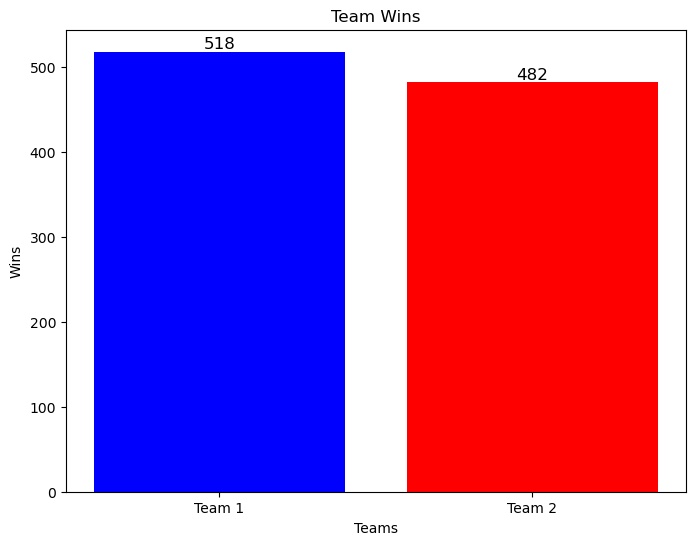

In [25]:
team_1_wins = np.sum(np.array(results['team_wins']) == 1)
team_2_wins = np.sum(np.array(results['team_wins']) == 2)

teams = ['Team 1', 'Team 2']
wins = [team_1_wins, team_2_wins]

plt.figure(figsize=(8, 6))
bars = plt.bar(teams, wins, color=['blue', 'red'])

for bar, win in zip(bars, wins):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(win), ha='center', va='bottom', fontsize=12, color='black')

plt.xlabel('Teams')
plt.ylabel('Wins')
plt.title('Team Wins')
plt.show()

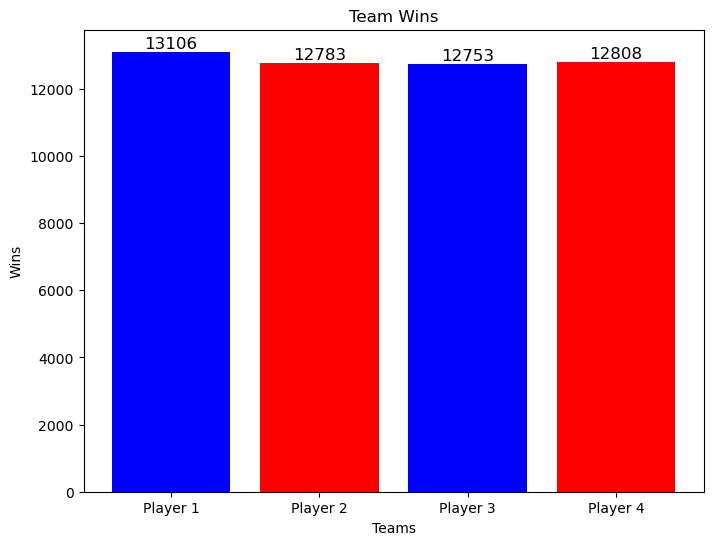

In [26]:
player_1_wins = np.sum(np.array(results['individual_wins']) == '1')
player_2_wins = np.sum(np.array(results['individual_wins']) == '2')
player_3_wins = np.sum(np.array(results['individual_wins']) == '3')
player_4_wins = np.sum(np.array(results['individual_wins']) == '4')

teams = ['Player 1', 'Player 2', 'Player 3', 'Player 4']
wins = [player_1_wins, player_2_wins, player_3_wins, player_4_wins]

plt.figure(figsize=(8, 6))
bars = plt.bar(teams, wins, color=['blue', 'red'])

for bar, win in zip(bars, wins):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(win), ha='center', va='bottom', fontsize=12, color='black')

plt.xlabel('Teams')
plt.ylabel('Wins')
plt.title('Team Wins')
plt.show()

## Incoporate Agents to Learn

TODO

Save Players

In [ ]:
with open('players.pkl', 'wb') as f:
    pickle.dump(players, f)

Load Players

In [6]:
with open('players.pkl', 'rb') as f:
    players = pickle.load(f)